In [8]:
import itertools
import numpy as np
from pathlib import Path
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam 
from torch.utils.data import DataLoader

from eff.data.dataset import CLTSDataset
from eff.train import get_class_weights_balanced, get_train_test_valid_split
from eff.train.dataset import TrainDataset, UnmaskedTestSet, \
    ConsonantMaskingTestSet, VowelMaskingTestSet
from eff.train.scripts import train, test
from eff.util import constants
from eff.util.util import save_results

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

base_path = Path("./out/art")

In [9]:
consonants = ["p", "t", "k", "b", "d", "g", "f", "s", "x", "v", "z", "r"]
front_vowels = ["æ", "e", "i"]
back_vowels = ["a", "o", "u"]

s_front = [[c+v for c in consonants] for v in front_vowels]
s_back = [[c+v for c in consonants] for v in back_vowels]

s_front = list(itertools.chain.from_iterable(s_front))
s_back = list(itertools.chain.from_iterable(s_back))

w_front = [[[s1+s2+s3 for s1 in s_front] for s2 in s_front] for s3 in s_front]
w_front = list(itertools.chain.from_iterable(itertools.chain.from_iterable(w_front)))
w_front = np.random.choice(w_front, size=2000)
print(len(w_front))
w_back = [[[s1+s2+s3 for s1 in s_back] for s2 in s_back] for s3 in s_back]
w_back = list(itertools.chain.from_iterable(itertools.chain.from_iterable(w_back)))
w_back = np.random.choice(w_back, size=2000)
print(len(w_back))
w_all = np.concatenate([w_front, w_back])
print(len(w_all))

print(w_front[:10], w_back[:10])

2000
2000
4000
['xibækæ' 'sæzevi' 'tisixi' 'bikeri' 'bækede' 'sedere' 'bibipi' 'gekexi'
 'vepæde' 'siferæ'] ['foruro' 'tatoga' 'bokara' 'datoku' 'bafasu' 'pasoxo' 'zutasu' 'tofosa'
 'gafosu' 'foruga']


In [10]:
batch_size = 32
n_layers = 2
embedding_size = 64
hidden_size = 256
dropout = 0.33
patience = 3

In [11]:
langs = dict(art1=w_all)

In [12]:
# %%capture log

from collections import defaultdict
import itertools

from eff.model import lstm
from eff.train import generate_batch

datasets = defaultdict(lambda: defaultdict(lambda: {}))
res = defaultdict(lambda: defaultdict(lambda: {}))
models = {}
criteria = {}

for lang_id, forms in langs.items():
    clts_dataset = CLTSDataset(forms)
    datasets['clts'] = clts_dataset
    print(clts_dataset.words[0])
    train_words, valid_words, test_words = get_train_test_valid_split(clts_dataset.words, \
        test_size=0.3, valid_size=0.1)

    train_set = TrainDataset(
                    words=train_words,
                    input_alphabet=clts_dataset.input_alphabet,
                    output_alphabet=clts_dataset.output_alphabet,
                    bipa=clts_dataset.bipa,
                    masking=0.01
                )
    valid_set = TrainDataset( 
                    words=valid_words,
                    input_alphabet=clts_dataset.input_alphabet,
                    output_alphabet=clts_dataset.output_alphabet,
                    bipa=clts_dataset.bipa, 
                    masking=0.01
                )
    test_set = UnmaskedTestSet(
                    words=test_words,
                    input_alphabet=clts_dataset.input_alphabet,
                    output_alphabet=clts_dataset.output_alphabet,
                    bipa=clts_dataset.bipa
                )
    
    test_set_vowel = VowelMaskingTestSet(
                        words=test_words,
                        input_alphabet=clts_dataset.input_alphabet,
                        output_alphabet=clts_dataset.output_alphabet,
                        bipa=clts_dataset.bipa
                    )

    test_set_consonant = ConsonantMaskingTestSet(
                            words=test_words,
                            input_alphabet=clts_dataset.input_alphabet,
                            output_alphabet=clts_dataset.output_alphabet,
                            bipa=clts_dataset.bipa
                        )

    datasets['torch']['unmasked'] = test_set
    datasets['torch']['vowel_masking'] = test_set_vowel
    datasets['torch']['consonant_masking'] = test_set_consonant

    train_loader = DataLoader(train_set, batch_size=batch_size, collate_fn=generate_batch)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, collate_fn=generate_batch)
    test_loader = DataLoader(test_set, batch_size=batch_size, collate_fn=generate_batch)
    test_loader_vowel = DataLoader(test_set_vowel, batch_size=batch_size, collate_fn=generate_batch)
    test_loader_consonant = DataLoader(test_set_consonant, batch_size=batch_size, collate_fn=generate_batch)
    
    train_labels = list(itertools.chain.from_iterable([t.cpu().tolist() for t in train_set._Y]))  
    
    missing_labels = list(set(clts_dataset.output_alphabet.indices).difference(set(train_labels)))
    train_labels = train_labels + [clts_dataset.output_alphabet.PAD_IDX] + missing_labels
    weight = get_class_weights_balanced(ignore_classes=[clts_dataset.pad_idx, clts_dataset.mask_idx], \
        classes=clts_dataset.output_alphabet.indices, y=train_labels)

    criterion = CrossEntropyLoss(weight=weight)
    criteria = criterion
    model = lstm.LstmLM(
        input_dim=len(clts_dataset.input_alphabet),
        output_dim=len(clts_dataset.output_alphabet),
        embedding_dim=64,
        hidden_dim=256,
        dropout=0.33,
        n_layers=2,
        loss_fn=criterion
    )
    # print(model)
    model.to(constants.device)
    optimizer = Adam(model.parameters())
    
    train(model, train_loader, valid_loader, optimizer, criterion, patience=patience)
    
    logprobs, target_indices, targets = test(model, test_loader, criterion)
    res['unmasked']['logprobs'] = logprobs
    res['unmasked']['targets'] = targets
    res['unmasked']['indices'] = target_indices
    
    logprobs, target_indices, targets = test(model, test_loader_vowel, criterion)
    res['vowel_masking']['logprobs'] = logprobs
    res['vowel_masking']['targets'] = targets
    res['vowel_masking']['indices'] = target_indices

    logprobs, target_indices, targets = test(model, test_loader_consonant, criterion)
    res['consonant_masking']['logprobs'] = logprobs
    res['consonant_masking']['targets'] = targets
    res['consonant_masking']['indices'] = target_indices


['x', 'i', 'b', 'æ', 'k', 'æ']
Epoch	Loss	Perplexity
1	0.0378	0	
2	0.0372	0	
3	0.0371	0	
4	0.0371	0	
Best epoch: 3, best valid loss: 0.04
Test loss: 0.03665370265642802
Test perplexity: 0
Test loss: 0.04783113807439804
Test perplexity: 0
Test loss: 0.036646208961804705
Test perplexity: 0


In [13]:
save_results(base_path, "art", datasets, res, criteria, models)

2400
2400


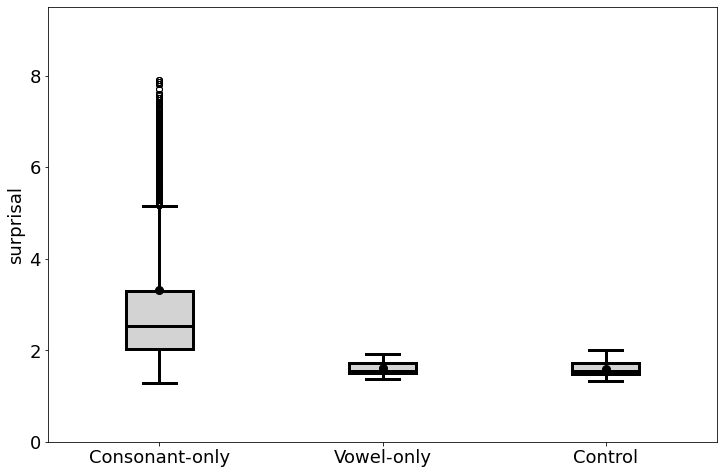

In [16]:
import matplotlib.pyplot as plt
from eff.analysis import surprisal
from eff.analysis.plotting import set_lang_ax

ignore_vowel_index=0

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1, 1, hspace=0.15, wspace=0.25)
ax = gs.subplots()

ax.set_ylim([0, 9.5])

surprisal_vowel = surprisal(
                        res['vowel_masking']['logprobs'],
                        res['vowel_masking']['targets'],
                        res['vowel_masking']['indices'],
                        ignore_vowel_index=999  
                        )
surprisal_consonant = surprisal(
                        res['consonant_masking']['logprobs'],
                        res['consonant_masking']['targets'],
                        res['consonant_masking']['indices'],
                        ignore_vowel_index=ignore_vowel_index
                        )
surprisal_none = surprisal(
                    res['unmasked']['logprobs'],
                    res['unmasked']['targets'],
                    res['unmasked']['indices'],
                    ignore_vowel_index=ignore_vowel_index
                    )


data = [surprisal_vowel, surprisal_consonant, surprisal_none]
xlabels = ["Consonant-only", "Vowel-only", "Control"]

set_lang_ax(ax, data, xlabels,
    # title="Artificial Langauge",
    title=None,
    boxcolor = "lightgrey",
    fontsize=18,
    ylabel="surprisal"
)

plt.savefig("../img/surprisal_art.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)

plt.show()